In [160]:
import sys
assert sys.version_info >= (3, 5)

import tensorflow as tf
assert tf.__version__ >= "2.0"
from tensorflow import keras

import numpy as np
import os

np.random.seed(42)

import matplotlib as mpl
import matplotlib.pyplot as plt

In [161]:
# Load the dataset:

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

In [162]:
# The MNIST training set contains 60,000 grayscale images, each 28x28 pixels:

X_train_full.shape

(60000, 28, 28)

In [163]:
# Each pixel intensity is represented as a byte (0 to 255):

X_train_full.dtype

dtype('uint8')

In [164]:
# Split the full training set into a validation set and a (smaller) training set. 
# We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255:

X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

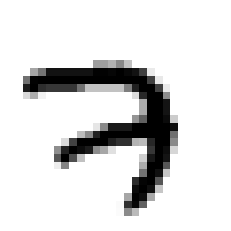

In [165]:
# Plot an image using Matplotlib's imshow() function, with a 'binary' color map:

plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [166]:
# The labels are the class IDs (represented as uint8), from 0 to 9. 
# Conveniently, the class IDs correspond to the digits represented in the images, so we don't need a class_names array:

y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

In [167]:
# The validation set contains 5,000 images, and the test set contains 10,000 images:

X_valid.shape

(5000, 28, 28)

In [168]:
X_test.shape

(10000, 28, 28)

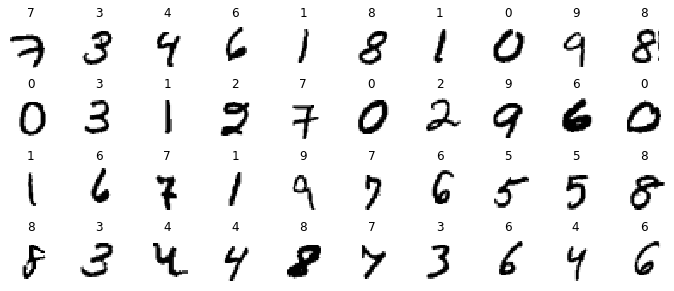

In [169]:
# A look at a sample of the images in the dataset:

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [170]:
# Building a simple dense network and find the optimal learning rate. 
# We will need a callback to grow the learning rate at each iteration. 
# It will also record the learning rate and the loss at each iteration:

K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [171]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [172]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="tanh"),
    keras.layers.Dense(100, activation="tanh"),
    keras.layers.Dense(10, activation="softmax")
])

In [173]:
# Start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration:

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

In [174]:
# Train the model for just 1 epoch:

history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

Train on 55000 samples, validate on 5000 samples
55000/55000 [==============================] - 4s 68us/sample - loss: 10.2389 - accuracy: 0.6825 - val_loss: 159.3772 - val_accuracy: 0.1070


Text(0, 0.5, 'Loss')

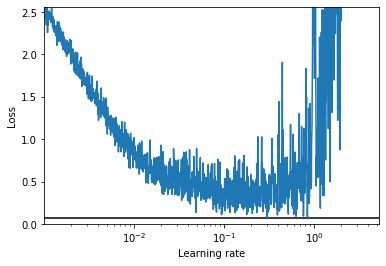

In [175]:
# Plotting the loss as a function of the learning rate:

plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [176]:
# The loss starts shooting back up violently around 3e-1, so let's try using 2e-1 as our learning rate:

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [177]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="tanh"),
    keras.layers.Dense(100, activation="tanh"),
    keras.layers.Dense(10, activation="softmax")
])

In [178]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=2e-1),
              metrics=["accuracy"])

In [179]:
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir

'.\\my_mnist_logs\\run_001'

In [180]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, checkpoint_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 3s 56us/sample - loss: 0.2602 - accuracy: 0.9216 - val_loss: 0.1387 - val_accuracy: 0.9614
Epoch 2/100
55000/55000 [==============================] - 3s 52us/sample - loss: 0.1195 - accuracy: 0.9640 - val_loss: 0.1099 - val_accuracy: 0.9702
Epoch 3/100
55000/55000 [==============================] - 3s 55us/sample - loss: 0.0852 - accuracy: 0.9733 - val_loss: 0.1034 - val_accuracy: 0.9694
Epoch 4/100
55000/55000 [==============================] - 3s 53us/sample - loss: 0.0629 - accuracy: 0.9802 - val_loss: 0.0972 - val_accuracy: 0.9742
Epoch 5/100
55000/55000 [==============================] - 3s 53us/sample - loss: 0.0493 - accuracy: 0.9847 - val_loss: 0.1124 - val_accuracy: 0.9660
Epoch 6/100
55000/55000 [==============================] - 3s 54us/sample - loss: 0.0367 - accuracy: 0.9887 - val_loss: 0.0800 - val_accuracy: 0.9784
Epoch 7/100
55000/55000 [==========================

In [181]:
model = keras.models.load_model("my_mnist_model.h5") # rollback to best model
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 34us/sample - loss: 0.0717 - accuracy: 0.9796


[0.07171884597159224, 0.9796]

In [113]:
# Change the activation function on the hidden layers to the hyperbolic tangent function.  
# What does this do to our accuracy? (that is, what accuracy did you observe?)

#      Changing the activation function on the hidden layers to the hyperbolic tanget function causes the accuracy to go down
#      to 97.96%